In [1]:
import random
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import spacy

# Data

## Tweet Content Extraction

In [2]:
'''
import requests
import os
import json

bearer_token = os.environ['BEARER_TOKEN']

def create_url(tweetIDS):
    ids = "ids=" + tweetIDS
    tweet_fields = "tweet.fields=source,lang,created_at,public_metrics,context_annotations"
    url = "https://api.twitter.com/2/tweets?{}&{}".format(ids, tweet_fields)
    return url


def bearer_oauth(r):
    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2TweetLookupPython"
    return r


def connect_to_endpoint(url):
    response = requests.request("GET", url, auth=bearer_oauth)
    print(response.status_code)
    if response.status_code != 200:
        raise Exception(
            "Request returned an error: {} {}".format(
                response.status_code, response.text
            )
        )
    return response.json()
''' ;

In [3]:
'''
tweetIDS = []
temp = ''
for count, val in enumerate(df['id']):
    temp = temp + val + ','
    if count != 0 and count % 99 == 0:
        temp = temp[:-1]
        tweetIDS.append(temp)
        temp = ''

tweetJSON = []

for i in tweetIDS:
    url = create_url(i)
    json_response = connect_to_endpoint(url)
    tweetJSON.append(json_response)

tweetDF = pd.DataFrame(columns=['id', 'lang', 'created_at', 'source', 'text', 'like_count', 'reply_count', 'quote_count'])

for val in tweetJSON:
    for i in val['data']:
        temp = {
            'id': i['id'],
            'lang': i['lang'],
            'created_at': i['created_at'],
            'source': i['source'],
            'text': i['text'],
            'like_count': i['public_metrics']['like_count'],
            'reply_count': i['public_metrics']['reply_count'],
            'quote_count': i['public_metrics']['quote_count']
        }
        
        tweetDF = tweetDF.append(temp, ignore_index=True)

tweetDF.to_csv('tweets.csv')
''' ;

## Loading Tweet ID's and Labels

In [4]:
# source: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0182487
df = pd.read_excel('./data/pone.0182487.s003.xlsx')
df.head()

,S1 Table - Tweet data and labels,Unnamed: 1
0,We have used the data according to the Twitter...,NaN
1,NaN,NaN
2,NaN,NaN
3,Tweet id,Label
4,732113301144883204,0


In [5]:
df = df.drop([0,1,2,3])
df = df.set_axis(['id', 'spam'], axis='columns')
df.head()

,id,spam
4,732113301144883204,0
5,732113301182746624,0
6,732113301145014272,0
7,732113301149089794,0
8,732113301178552320,0


## Merging Tweet ID's with Content

In [6]:
tweetDF = pd.read_csv('./data/tweets.csv', index_col=[0])
tweetDF['id'] = tweetDF['id'].astype(str)
tweetDF['source'] = tweetDF['source'].astype(str)
tweetDF['text'] = tweetDF['text'].astype(str)


df['id'] = df['id'].astype(str)
df['spam'] = df['spam'].astype(int)

df = pd.merge(tweetDF,df, how='inner', on='id')
df.head()

,id,lang,created_at,source,text,like_count,reply_count,quote_count,spam
0,732113301182746624,en,2016-05-16T07:39:47.000Z,Tweetbot for iΟS,RT @odinodin: I just made a tool for inspectin...,0,0,0,0
1,732113301145014272,en,2016-05-16T07:39:47.000Z,Twitter for Android,HAPPY BIRTHDAY JOSEPH 💓 @JosephMorgan,0,0,0,0
2,732113301149089794,en,2016-05-16T07:39:47.000Z,Twitter for iPad,RT @zeecinema: Yeh inka dopahar ka program hai...,0,0,0,0
3,732113305376940032,en,2016-05-16T07:39:48.000Z,Twitter for Android,RT @iitian_kshitij: Actually they have become ...,0,0,0,0
4,732113305347612672,en,2016-05-16T07:39:48.000Z,Twitter for iPhone,@JaimesonPaul lock all windows and doors don't...,0,1,0,0


# Preprocessing

In [7]:
np.random.seed(0)

## SPAM Distribution

Positive Count: 3345
Negative Count: 43390
Spam to Non-Spam Ratio: 0.07157376698405905


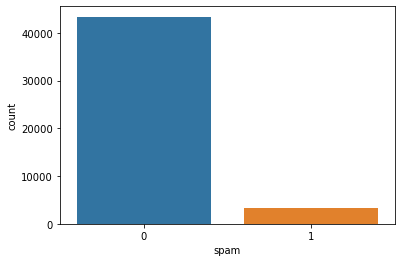

In [8]:
positive = df[df['spam']==1].shape[0]
negative = df[df['spam']==0].shape[0]

sns.countplot(data=df, x='spam')

print('Positive Count:', positive)
print('Negative Count:', negative)
print('Spam to Non-Spam Ratio:', positive/(positive + negative))

- The classes within the spam label are super imbalanced, this could affect model performance and metric interpretability

## Class Balancing

In [9]:
class_size = 15000

positive_indexes = list(df[df['spam']==1].index)
negative_indexes = list(df[df['spam']==0].index)

positive_samples = list(np.random.choice(positive_indexes, size=(class_size)))
negative_samples = list(np.random.choice(negative_indexes, size=(class_size)))
samples = positive_samples + negative_samples

temp_df = pd.DataFrame(data=samples, columns=['index_id'])
df = pd.merge(df, temp_df, how='inner', left_index=True, right_on='index_id')
df = df.reset_index()
df.head()

,index,id,lang,created_at,source,text,like_count,reply_count,quote_count,spam,index_id
0,18129,732113301149089794,en,2016-05-16T07:39:47.000Z,Twitter for iPad,RT @zeecinema: Yeh inka dopahar ka program hai...,0,0,0,0,2
1,569,732113305343426560,en,2016-05-16T07:39:48.000Z,Twitter for iPhone,Same 😭 https://t.co/1GHDWGWzrC,1,0,0,1,6
2,833,732113305343426560,en,2016-05-16T07:39:48.000Z,Twitter for iPhone,Same 😭 https://t.co/1GHDWGWzrC,1,0,0,1,6
3,3001,732113305343426560,en,2016-05-16T07:39:48.000Z,Twitter for iPhone,Same 😭 https://t.co/1GHDWGWzrC,1,0,0,1,6
4,5373,732113305343426560,en,2016-05-16T07:39:48.000Z,Twitter for iPhone,Same 😭 https://t.co/1GHDWGWzrC,1,0,0,1,6


- Used numpy to sample 15,000 observations with replacement from both spam and non-spam tweets

## SPAM Distribution

Positive Count: 15000
Negative Count: 15000
Spam to Non-Spam Ratio: 0.5


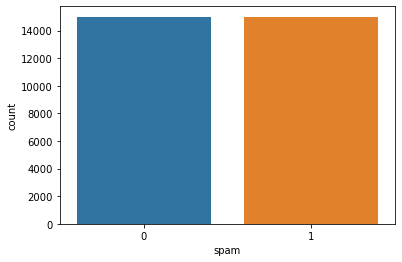

In [10]:
positive = df[df['spam']==1].shape[0]
negative = df[df['spam']==0].shape[0]

sns.countplot(data=df, x='spam')

print('Positive Count:', positive)
print('Negative Count:', negative)
print('Spam to Non-Spam Ratio:', positive/(positive + negative))

## Cleaning

In [11]:
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words

def clean_text(x):
    doc = nlp(x.lower())
    lemmas = [token.lemma_ for token in doc 
          if token.lemma_.isalnum() and token.lemma_ not in stopwords]
    x = ' '.join(lemmas)
    return x

In [12]:
df['text'] = df['text'].apply(clean_text)

- Using spacy, stop words were removed, tokens that don't contain letters of the alphabet or numbers were removed (i.e. punctuation, emojis), and tokens were lemmatized
- This helps reduce dimensions in tokenization (feature engineering) along with improve model performance 

# Machine Learning

In [65]:
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, PrecisionRecallDisplay, roc_curve, auc, RocCurveDisplay

## Predicting SPAM with Tweet Content

### Train Test Split

In [66]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['spam'], test_size=1/3)

### Vectorization

In [72]:
vectorizer_names = ['Tfidf', '1-Gram', '2-Gram']
vectorizers = [TfidfVectorizer(), CountVectorizer(ngram_range=(1,1)), CountVectorizer(ngram_range=(1,2))]
vectorized_data = []
vocabulary = []

for cnt, vectorizer in enumerate(vectorizers):
    vectorizer_x_train = vectorizer.fit_transform(X_train)
    vectorizer_x_test = vectorizer.transform(X_test)
    vectorized_data.append((vectorizer_x_train, vectorizer_x_test))
    
    if vectorizer_names[cnt] in ['1-Gram', '2-Gram']:
        x = list(vectorizer_x_train.toarray().sum(axis=0))
        x = sorted(list(zip(np.arange(len(x)), x)), key=lambda y:y[1], reverse=True)
        print(vectorizer_names[cnt], 'Most Frequent Words')
        print('------------------------------------------')
        for index, word_count in x[:10]:
            print(vectorizer.get_feature_names_out()[index], word_count)
        print('\n')

1-Gram Most Frequent Words
------------------------------------------
rt 4929
weather 1755
update 1342
follow 1074
today 930
like 923
amp 899
theweatherchannel 861
new 840
find 758


2-Gram Most Frequent Words
------------------------------------------
rt 4929
weather 1755
update 1342
weather update 1292
follow 1074
today 930
like 923
amp 899
theweatherchannel 861
update theweatherchannel 861




- Training and testing data were created for each vectorization method

Predicting SPAM using Logistic Regression
**********************************************************************************
Utilizing Tfidf vectorized data:
---------------------------------------------------------
Accuracy: 0.9369
Precision: 0.9608879492600423
Recall: 0.9106391504708475
F1: 0.9350889826149574
Confusion Matrix:
 [[4824  185]
 [ 446 4545]]


Precision vs. Recall Curve


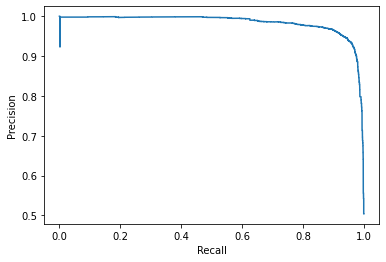

True Positive vs. False Positive (ROC Curve)


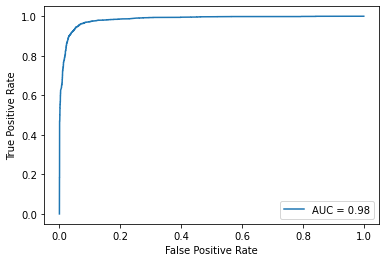

Utilizing 1-Gram vectorized data:
---------------------------------------------------------
Accuracy: 0.9615
Precision: 0.9624497991967872
Recall: 0.9603285914646363
F1: 0.9613880252732926
Confusion Matrix:
 [[4822  187]
 [ 198 4793]]


Precision vs. Recall Curve


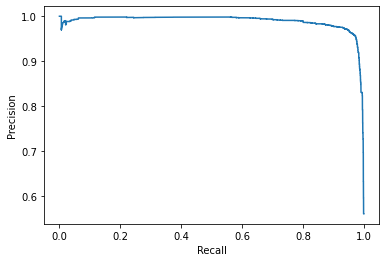

True Positive vs. False Positive (ROC Curve)


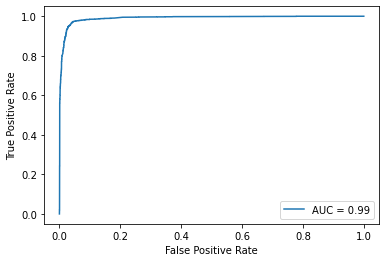

Utilizing 2-Gram vectorized data:
---------------------------------------------------------
Accuracy: 0.9777
Precision: 0.9781387886081027
Recall: 0.9771588859947906
F1: 0.9776485917610503
Confusion Matrix:
 [[4900  109]
 [ 114 4877]]


Precision vs. Recall Curve


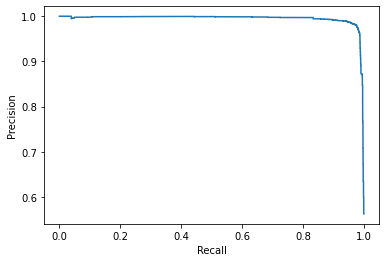

True Positive vs. False Positive (ROC Curve)


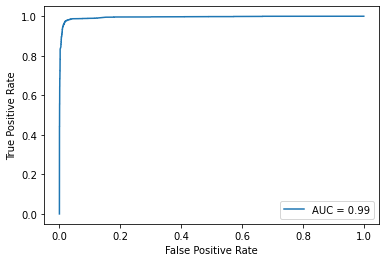

Predicting SPAM using K-Nearest Neighbor
**********************************************************************************
Utilizing Tfidf vectorized data:
---------------------------------------------------------
Accuracy: 0.9176
Precision: 0.9054290718038529
Recall: 0.9322781005810459
F1: 0.9186574531095755
Confusion Matrix:
 [[4523  486]
 [ 338 4653]]


Precision vs. Recall Curve


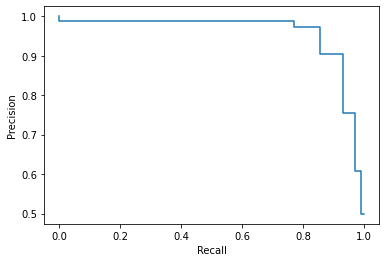

True Positive vs. False Positive (ROC Curve)


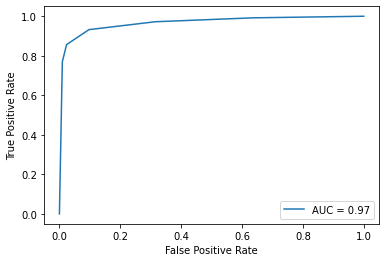

Utilizing 1-Gram vectorized data:
---------------------------------------------------------
Accuracy: 0.9295
Precision: 0.9198667711598746
Recall: 0.9406932478461231
F1: 0.9301634472511144
Confusion Matrix:
 [[4600  409]
 [ 296 4695]]


Precision vs. Recall Curve


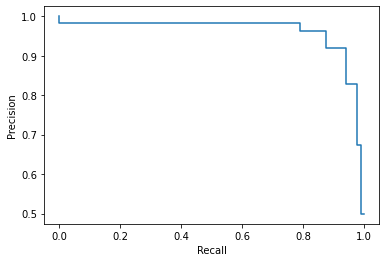

True Positive vs. False Positive (ROC Curve)


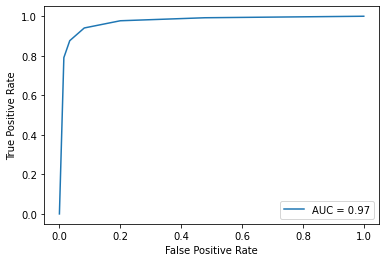

Utilizing 2-Gram vectorized data:
---------------------------------------------------------
Accuracy: 0.9275
Precision: 0.9333604225924421
Recall: 0.9204568222801042
F1: 0.9268637143145364
Confusion Matrix:
 [[4681  328]
 [ 397 4594]]


Precision vs. Recall Curve


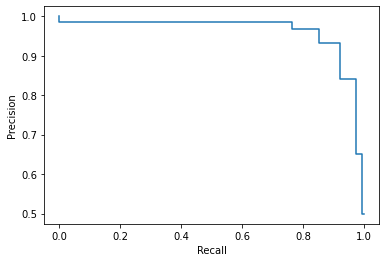

True Positive vs. False Positive (ROC Curve)


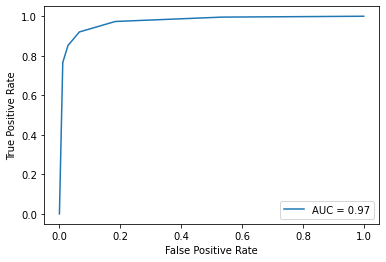

Predicting SPAM using Random Forest
**********************************************************************************
Utilizing Tfidf vectorized data:
---------------------------------------------------------
Accuracy: 0.9828
Precision: 0.9791210976337243
Recall: 0.9865758365057102
F1: 0.9828343313373253
Confusion Matrix:
 [[4904  105]
 [  67 4924]]


Precision vs. Recall Curve


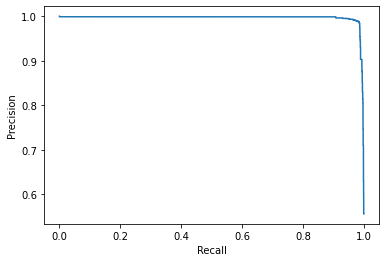

True Positive vs. False Positive (ROC Curve)


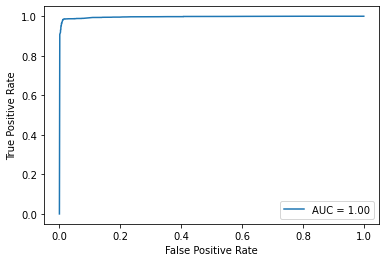

Utilizing 1-Gram vectorized data:
---------------------------------------------------------
Accuracy: 0.9769
Precision: 0.9663009404388715
Recall: 0.9881787216990583
F1: 0.977117384843982
Confusion Matrix:
 [[4837  172]
 [  59 4932]]


Precision vs. Recall Curve


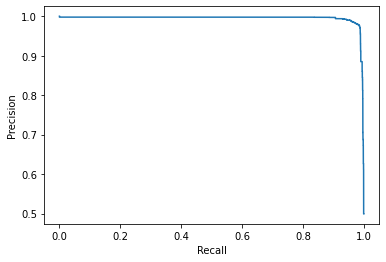

True Positive vs. False Positive (ROC Curve)


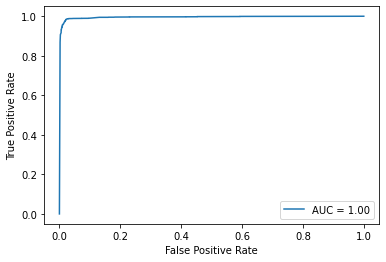

Utilizing 2-Gram vectorized data:
---------------------------------------------------------
Accuracy: 0.9791
Precision: 0.9708546671918078
Recall: 0.9877780004007213
F1: 0.9792432217697885
Confusion Matrix:
 [[4861  148]
 [  61 4930]]


Precision vs. Recall Curve


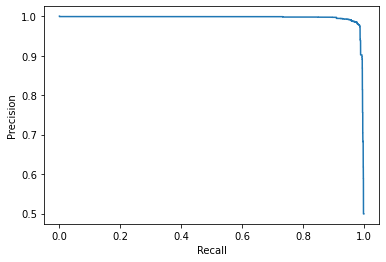

True Positive vs. False Positive (ROC Curve)


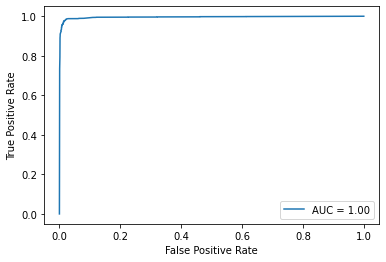

Predicting SPAM using Naive Bayes
**********************************************************************************
Utilizing Tfidf vectorized data:
---------------------------------------------------------
Accuracy: 0.9259
Precision: 0.9183070866141733
Recall: 0.934682428371068
F1: 0.9264224009532321
Confusion Matrix:
 [[4594  415]
 [ 326 4665]]


Precision vs. Recall Curve


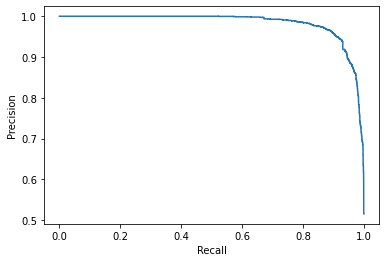

True Positive vs. False Positive (ROC Curve)


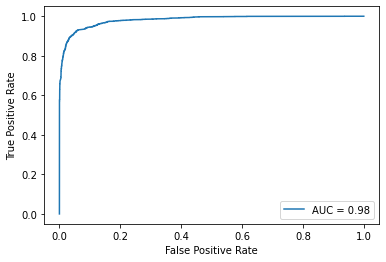

Utilizing 1-Gram vectorized data:
---------------------------------------------------------
Accuracy: 0.9255
Precision: 0.9182427107959023
Recall: 0.9338809857743939
F1: 0.9259958279527167
Confusion Matrix:
 [[4594  415]
 [ 330 4661]]


Precision vs. Recall Curve


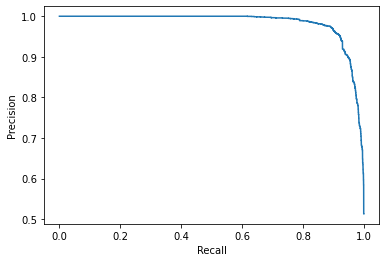

True Positive vs. False Positive (ROC Curve)


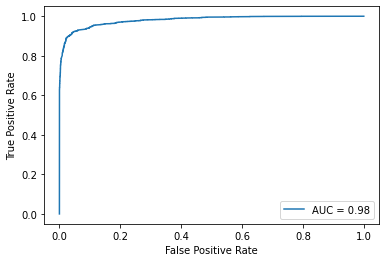

Utilizing 2-Gram vectorized data:
---------------------------------------------------------
Accuracy: 0.9555
Precision: 0.9300037835792659
Recall: 0.9849729513123623
F1: 0.9566994259025008
Confusion Matrix:
 [[4639  370]
 [  75 4916]]


Precision vs. Recall Curve


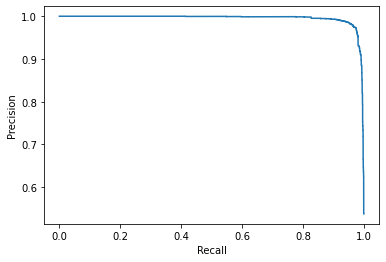

True Positive vs. False Positive (ROC Curve)


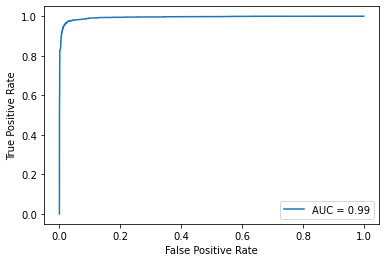

In [17]:
model_names = ['Logistic Regression', 
               'K-Nearest Neighbor', 
               'Random Forest',
               'Naive Bayes']

models = [LogisticRegression(), 
          KNeighborsClassifier(),
          RandomForestClassifier(), 
          MultinomialNB()]

metric_names = ['Accuracy', 'Precision', 'Recall', 'F1']
models_metrics = []

for cnt, model in enumerate(models):
    
    print('Predicting SPAM using {}'.format(model_names[cnt]))
    print('**********************************************************************************')
    i=0
    
    metrics = []
    
    for X_train, X_test in vectorized_data:
        
        print('Utilizing {} vectorized data:'.format(vectorizer_names[i]))
        print('---------------------------------------------------------')
        
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        
        temp_metrics = [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)] 
        metrics.append(temp_metrics)
        
        print('Accuracy:', temp_metrics[0])
        print('Precision:', temp_metrics[1])
        print('Recall:', temp_metrics[2])
        print('F1:', temp_metrics[3])
        print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
        print('\n')
                
        y_probs = model.predict_proba(X_test)
        
        print('Precision vs. Recall Curve')
        precision, recall, _ = precision_recall_curve(y_test, y_probs[:, 1])
        disp = PrecisionRecallDisplay(precision=precision, recall=recall)
        disp.plot()
        plt.show()
        
        print('True Positive vs. False Positive (ROC Curve)')
        fpr, tpr, thresholds = roc_curve(y_test, y_probs[:, 1])
        roc_auc = auc(fpr, tpr)
        display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
        display.plot()
        plt.show()

        
        i+=1
        
    models_metrics.append(metrics)
    

## Metric Visualization

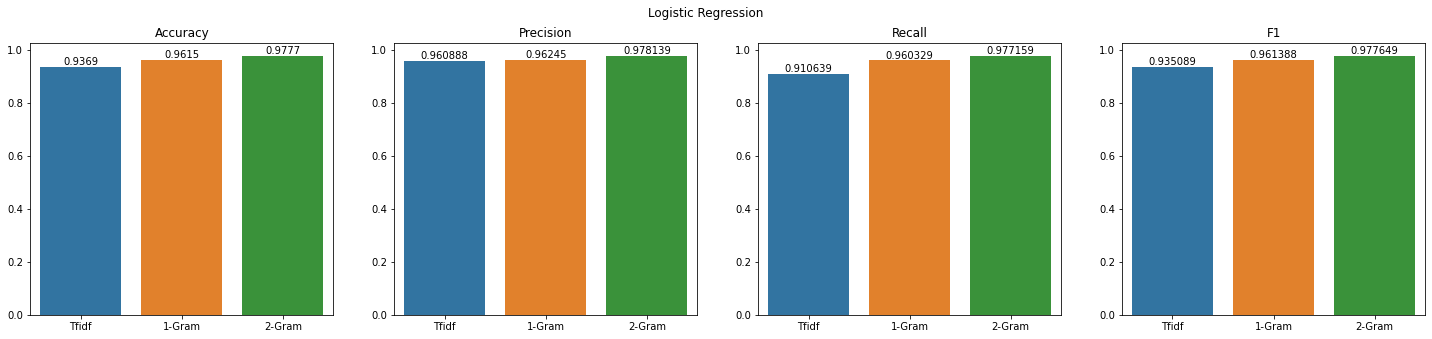

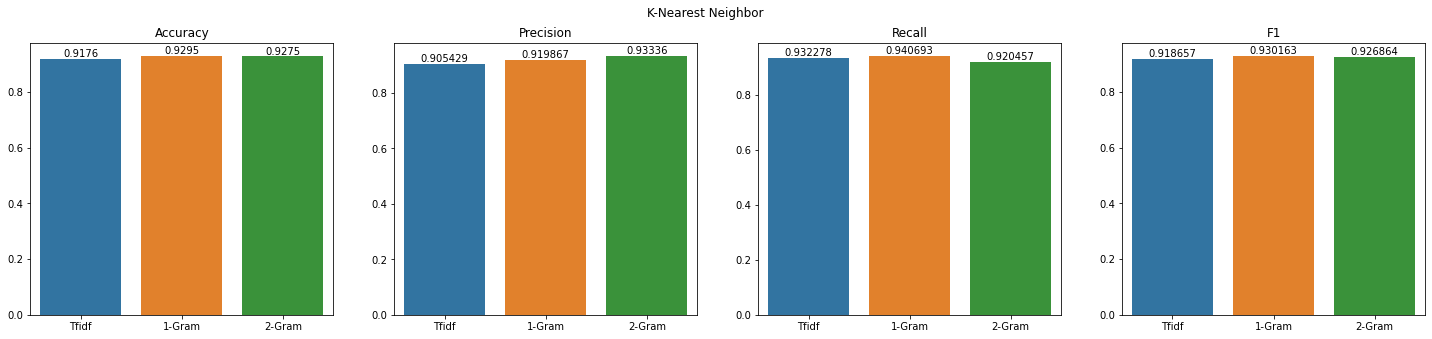

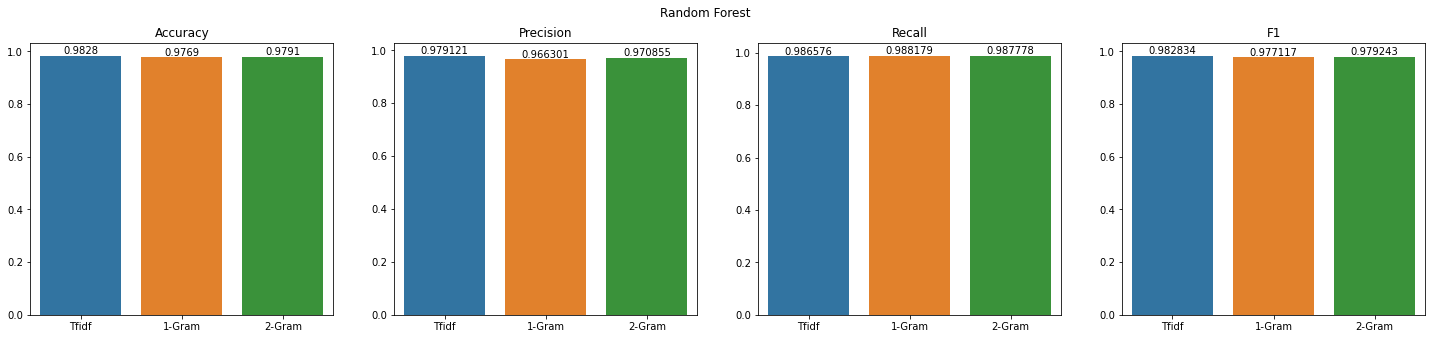

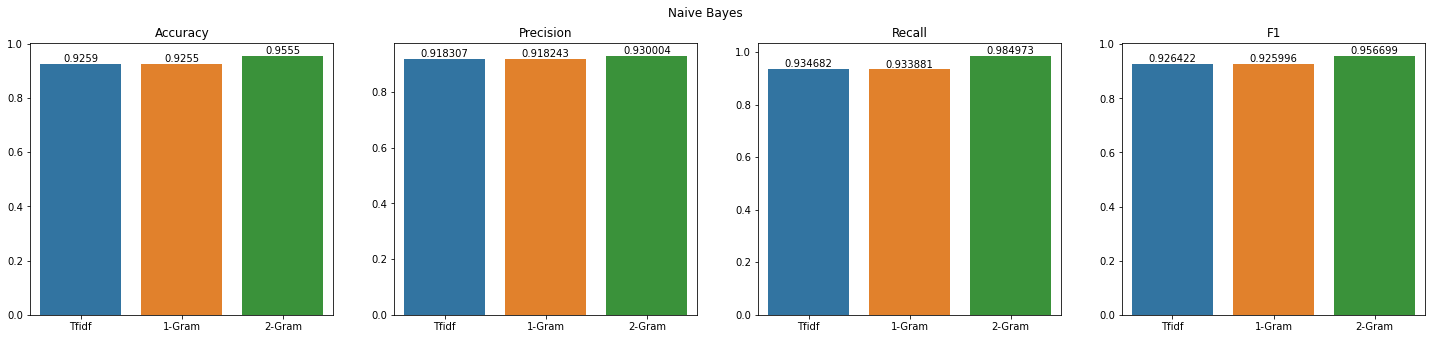

In [18]:
models_metrics = np.array(models_metrics)
for cnt, name in enumerate(model_names):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, len(metric_names), figsize=(25,5))
    fig.suptitle(name)
    
    sns.barplot(x=vectorizer_names, y=models_metrics[cnt][:,0], ax=ax1)
    sns.barplot(x=vectorizer_names, y=models_metrics[cnt][:,1], ax=ax2)
    sns.barplot(x=vectorizer_names, y=models_metrics[cnt][:,2], ax=ax3)
    sns.barplot(x=vectorizer_names, y=models_metrics[cnt][:,3], ax=ax4)

    
    ax1.bar_label(ax1.containers[0])
    ax2.bar_label(ax2.containers[0])
    ax3.bar_label(ax3.containers[0])
    ax4.bar_label(ax4.containers[0])
    
    ax1.set_title('Accuracy')
    ax2.set_title('Precision')
    ax3.set_title('Recall')
    ax4.set_title('F1')
    
    plt.show()

Best and Worst Vectorizers

- Logistic Regression
    - Best Accuracy: **2-gram**
    - Worst Accuracy: **tf-idf**
    - Best F1: **2-gram**
    - Worst F1: **tf-idf**
- K-Nearest Neighbors
    - Best Accuracy: **1-gram**
    - Worst Accuracy: **tf-idf**
    - Best F1: **1-gram**
    - Worst F1: **tf-idf**
- Random Forest
    - Best Accuracy: **tf-idf**
    - Worst Accuracy: **1-gram**
    - Best F1: **tf-idf**
    - Worst F1: **1-gram**
- Naive Bayes
    - Best Accuracy: **2-gram**
    - Worst Accuracy: **1-gram**
    - Best F1: **1-gram**
    - Worst F1: **2-gram**

---
---

Best Performing Models
- Accuracy: **Random Forest**
- Precision: **Random Forest**
- Recall: **Random Forest**
- F1: **Random Forest**


### The best perfoming model was the Random Forest Classifier. Regardless of vectorization method used for training, consistent and impressive metrics were produced. The other classifiers were stronger or weaker depending on vectorization. In conclusion to predict Twitter SPAM, the best model and vectorization methods are random forest  and 2-gram, respectivley.
